# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, DecisionTreeClassifier,NaiveBayes,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, Normalizer, PCA, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import timeit
import time

import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Capstone Project") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# filter for users with blank user id
blank_pages = df.filter(df.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

In [6]:
blank_pages.show()

+-------------------+
|        blank_pages|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [7]:
df.count()

286500

In [8]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [9]:
# drop na values from the userId, sessionId
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"]).dropDuplicates()

In [10]:
# drop empty values from the userId
df_clean = df_clean.filter(df_clean["userId"] != "")

In [11]:
a=df_clean.toPandas()

In [12]:
a.isnull().sum()

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
dtype: int64

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
# funtion to input 1 if the user goes to cancellation confirmation
flag_Cancellation_Confirmation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())


# window partitioned by user in order to input 1 to churn users
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

#apply funtion and window
df_clean_Churn = df_clean.withColumn("Churn", flag_Cancellation_Confirmation("page"))
df_clean_Churn = df_clean_Churn.withColumn("Churn", Fsum("Churn").over(windowval))

In [14]:
df_clean_Churn.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Bebe,Logged In,Darianna,F,1,Carpenter,225.77587,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,174,Men SeÃÂ±arÃÂ¡,200,1541731859000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,The Ruts,Logged In,Darianna,F,44,Carpenter,338.96444,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,118,West One (Shine On Me),200,1540052737000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,None,Logged In,Darianna,F,21,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Logout,1538016340000,133,None,307,1541415422000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,Shakira,Logged In,Darianna,F,51,Carpenter,363.38893,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,133,Octavo DÃÂ­a,200,1541419901000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,None,Logged In,Darianna,F,100,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Roll Advert,1538016340000,174,None,200,1541749370000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [15]:
#give better format to timestamp fields
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
#ts field
df_clean_Churn = df_clean_Churn.withColumn("date_hour", get_date(df_clean_Churn.ts))
#registration field
df_clean_Churn = df_clean_Churn.withColumn("registration_date", get_date(df_clean_Churn.registration))

In [16]:
#let's see how the date looks like
df_clean_Churn.select(['date_hour',"registration_date"] ).show(5)

+-------------------+-------------------+
|          date_hour|  registration_date|
+-------------------+-------------------+
|2018-10-01 05:52:13|2018-09-30 10:47:35|
|2018-10-01 05:52:14|2018-09-30 10:47:35|
|2018-10-01 09:08:44|2018-09-07 02:24:59|
|2018-10-01 11:54:38|2018-09-29 16:37:25|
|2018-10-01 14:00:23|2018-08-14 11:26:36|
+-------------------+-------------------+
only showing top 5 rows



In [17]:
df_clean_Churn.dropDuplicates(['userID']).groupby(['gender', 'Churn']).count().show(5)

+------+-----+-----+
|gender|Churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [18]:
df_clean_Churn.groupby(['userID']).count().show(5)

+------+-----+
|userID|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
+------+-----+
only showing top 5 rows



Now I am going to visualize the difference between male and female in both groups

In [19]:
df_clean_Churn.dropDuplicates(['userID']).groupby(['gender', 'Churn']).count().show(5)

+------+-----+-----+
|gender|Churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



From this table we can also see that we have about 23% of users that have churned ( unbalanced dataset)

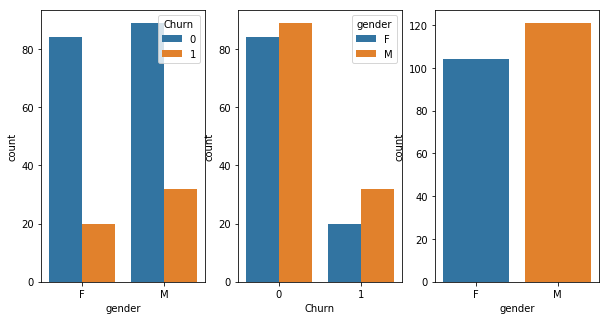

In [20]:
#plot  bar charts to see the Churn vs Gender
data=df_clean_Churn.dropDuplicates(['userID']).groupby(['gender', 'Churn']).count().toPandas()
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.barplot(x='gender', y='count', hue='Churn', data=data,ax=ax[0])
sns.barplot(x='Churn', y='count', hue='gender', data=data,ax=ax[1])
sns.barplot(x='gender', y='count', data=data.groupby('gender',as_index=False).sum(),ax=ax[2])

We can observe a bigger difference in the Churn group and it seems that the male tend to churn more than the female. It is something to take into account in further analysis.

Now I am going to explore the sessionID field in order to know further about it 

In [21]:
#let's show an example of sessionId
df_clean_Churn.select(['sessionId','page','date_hour',"userId"]).filter(df_clean_Churn.sessionId==1).orderBy('date_hour').dropDuplicates(['userID']).show(100)

+---------+--------+-------------------+------+
|sessionId|    page|          date_hour|userId|
+---------+--------+-------------------+------+
|        1|    Home|2018-10-01 10:34:42|300001|
|        1|NextSong|2018-10-08 04:49:55|     2|
|        1|    Home|2018-10-01 06:48:24|100001|
+---------+--------+-------------------+------+



In [22]:
df_clean_Churn.groupby(['sessionId', 'userId']).count().sort('sessionId').show()

+---------+------+-----+
|sessionId|userId|count|
+---------+------+-----+
|        1|     2|  428|
|        1|300001|  201|
|        1|100001|   51|
|        2|200002|    7|
|        3|300003|   35|
|        3|100003|    2|
|        4|100004|   24|
|        5|     6|    5|
|        5|100005|   52|
|        6|300006|   24|
|        6|100006|   44|
|        7|200007|    1|
|        8|     9|   45|
|        9|300009|   92|
|        9|    10|   70|
|        9|100009|   28|
|       10|    11|    9|
|       10|300010|   70|
|       10|200010|   86|
|       11|300011|   21|
+---------+------+-----+
only showing top 20 rows



Ohh, I see that there are differet userId for the same sessionId which is a bit strange. It supposes the sessionId to be unique... so in  this study I am not going to use the sessionIds lenghts which could be a very good feature to understand the Churn

In order to compare the distribution of pages interation between Churn and Nonchurn groups, I am going to make a boxplot per page.

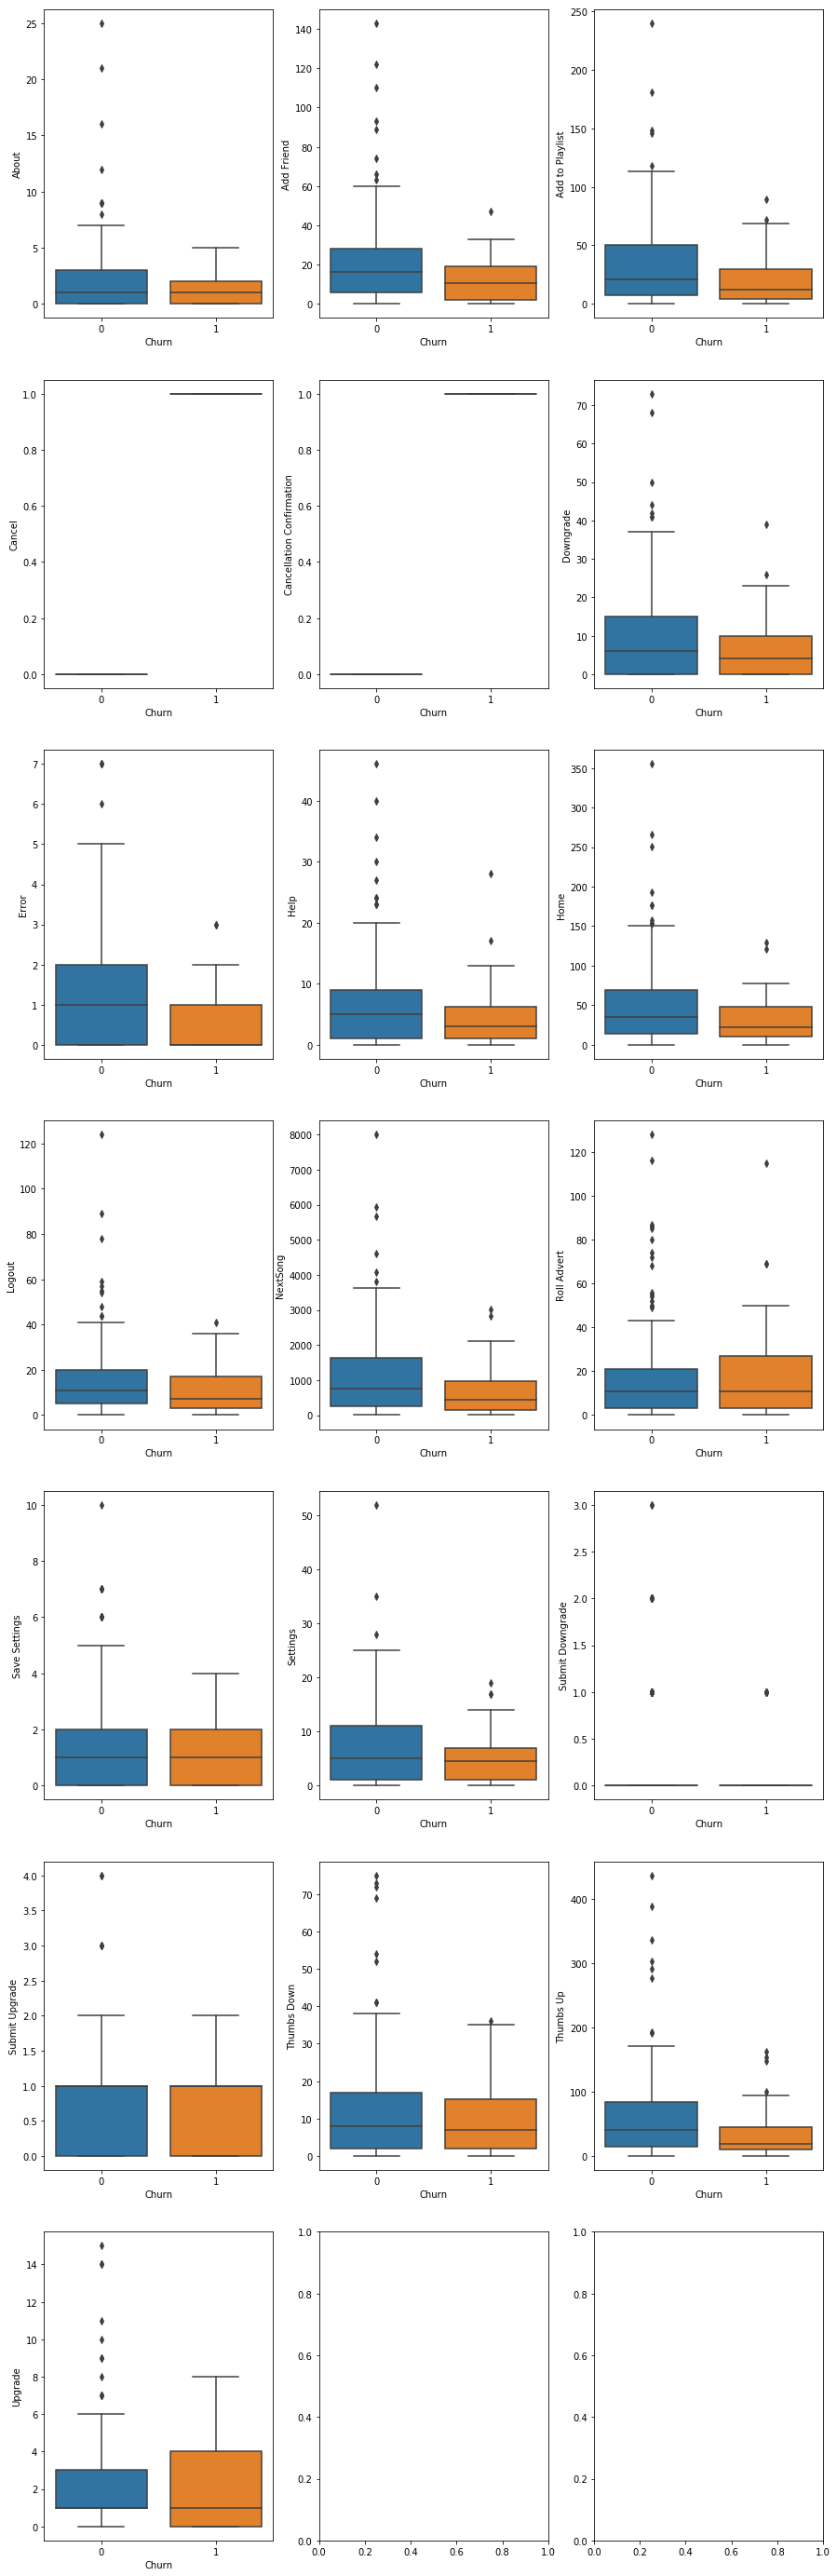

In [23]:
#data frame of the counts per page by means of pivoting
data_box=df_clean_Churn.groupby(['userId','Churn']).pivot('page').count().toPandas().fillna(value=0)

#list of page to be mapped
columns = list(data_box.columns)
columns.remove('userId')# we delete userId as it is not necessary 
columns.remove('Churn')# we delete Churn as it is the x variable

#plot histograms of all pages
fig, ax = plt.subplots(7, 3, figsize=(15, 50))
for var, subplot in zip(columns, ax.flatten()):
    sns.boxplot(x='Churn', y=var, data=data_box, ax=subplot)

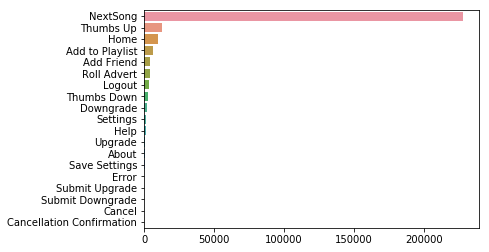

In [24]:
#barchart of the pages per count
data_bar=data_box.sum().sort_values(ascending=False).drop(['userId','Churn'])
sns.barplot(x=data_bar, y=data_bar.index,orient='h');

In [25]:
#print the statics of the events

print ('Statics for Churn =0')
print(data_box[data_box.Churn==0][columns].describe())
print ("\n")
print ('Statics for Churn =1')
print(data_box[data_box.Churn==1][columns].describe())

Statics for Churn =0
            About  Add Friend  Add to Playlist  Cancel  \
count  173.000000  173.000000       173.000000   173.0   
mean     2.537572   21.046243        31.722543     0.0   
std      3.426136   22.286667        35.056821     0.0   
min      0.000000    0.000000         0.000000     0.0   
25%      0.000000    6.000000         7.000000     0.0   
50%      1.000000   16.000000        21.000000     0.0   
75%      3.000000   28.000000        50.000000     0.0   
max     25.000000  143.000000       240.000000     0.0   

       Cancellation Confirmation   Downgrade       Error        Help  \
count                      173.0  173.000000  173.000000  173.000000   
mean                         0.0    9.930636    1.271676    7.023121   
std                          0.0   12.513520    1.585236    7.664441   
min                          0.0    0.000000    0.000000    0.000000   
25%                          0.0    0.000000    0.000000    1.000000   
50%                     

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

First I am going to pivot the data frame in order to get the pages interaction as features (19 feature) however we need to delete cancelation confirmation in order to avoid leak in the model

In [26]:
#create a data frame with the pages/count
df_page=df_clean_Churn.groupby(['userId','Churn']).pivot('page').count().fillna(value=0)
columns_to_drop = ["Cancellation Confirmation","cancel"]
df_page = df_page.drop(*columns_to_drop)

In [27]:
df_page.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Churn: long (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)



**Aditional Feature1** Unique artist count

In [28]:
uniqueartist_count_df=df_clean.select("userId", "artist").groupby("userId")\
    .agg(F.countDistinct("artist").alias("UniqueArtistCount"))

In [29]:
uniqueartist_count_df.show(5)

+------+-----------------+
|userId|UniqueArtistCount|
+------+-----------------+
|100010|              252|
|200002|              339|
|   125|                8|
|   124|             2232|
|    51|             1385|
+------+-----------------+
only showing top 5 rows



**Aditional Feature2** Gender

In [30]:
gender_df= df_clean.select("userId", "gender").dropDuplicates()

In [31]:
#let's convert Male in 1 and Female 0
flag_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
gender_df = gender_df.withColumn("gender", flag_gender("gender"))

In [32]:
gender_df.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    35|     0|
|    40|     0|
|    75|     0|
+------+------+
only showing top 10 rows



**Aditional Feature3** Unique Song

We already have the number of songs if the feature "NextSong" but it would be good to have the unique Songs because it has information about how much the user repeat songs.

In [33]:
uniquesound_df = df_clean.select("userId", "song").groupby("userId") \
    .agg(F.countDistinct("song").alias("UniqueSongCount"))

In [34]:
uniquesound_df.show(10)

+------+---------------+
|userId|UniqueSongCount|
+------+---------------+
|100010|            269|
|200002|            378|
|   125|              8|
|    51|           1854|
|   124|           3339|
|     7|            148|
|    54|           2414|
|    15|           1707|
|   155|            759|
|   132|           1718|
+------+---------------+
only showing top 10 rows



**Aditional Feature4** Total Events

In [35]:
totalevents_df = df_clean.groupby(['userID']).count()\
    .withColumnRenamed(("count"), ("totalevents"))

In [36]:
totalevents_df.show(5)

+------+-----------+
|userID|totalevents|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
+------+-----------+
only showing top 5 rows



Finally I am going to make two functions agrouping the code above: one for cleanning the dataset and the other for feature enginering in order to make it cleaner and scalable for the full dataset.

In [37]:
def clean_df(df):
    
    """
    This function is used to clean the row dataset
    input: dataframe to be cleaned
    output: final clean dataframe 
    """   
    # drop na values from the userId, sessionId
    df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"]).dropDuplicates()
    # drop empty values from the userId
    df_clean = df_clean.filter(df_clean["userId"] != "")
    
    return df_clean

In [38]:
def features_enginering(df):
    
    """
    This function is used to make the feature engineering
    input: data frame alredy cleaned
    output: final data frame for modeling
    """    
 

    # funtion to input 1 if the user goes to cancellation confirmation
    flag_Cancellation_Confirmation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    # window partitioned by user in order to input 1 to churn users
    windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    #apply funtion and window
    df_clean_Churn = df.withColumn("label", flag_Cancellation_Confirmation("page"))# we call label instead of churn
    df_clean_Churn = df_clean_Churn.withColumn("label", Fsum("label").over(windowval)) 
    
    
    
    #create the data frame with the pages/count and remove "Cancellation Confirmation","cancel" to avoid leaks
    df_page=df_clean_Churn.groupby(['userId','label']).pivot('page').count().fillna(value=0)
    columns_to_drop = ["Cancellation Confirmation","cancel"]
    df_page = df_page.drop(*columns_to_drop)
    
    #aditional feature: UniqueArtistcount
    uniqueartist_count_df=df_clean.select("userId", "artist").groupby("userId")\
    .agg(F.countDistinct("artist").alias("UniqueArtistCount"))
    
    
    #aditional feature: Gender
    flag_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
    gender_df= df_clean.select("userId", "gender").dropDuplicates()
    gender_df = gender_df.withColumn("gender", flag_gender("gender"))
    
    
    #aditional feature: UniqueSong
    uniquesound_df = df_clean.select("userId", "song").groupby("userId") \
    .agg(F.countDistinct("song").alias("UniqueSongCount"))
    
    #aditional feature: Total_events
    totalevents_df = df_clean.groupby(['userID']).count()\
    .withColumnRenamed(("count"), ("totalevents"))
    
    #let's join all the dataframes together
    
    #list_df= [df_page,artist_count_df,gender_df,uniquesound_df]  
    
    final_df = df_page.join(uniqueartist_count_df, ['userId'])
    final_df = final_df.join(gender_df, ['userId'])     
    final_df = final_df.join(uniquesound_df, ['userId'])
    final_df = final_df.join(totalevents_df, ['userId'])
        
    return final_df


In [39]:
df_page= features_enginering(df_clean)

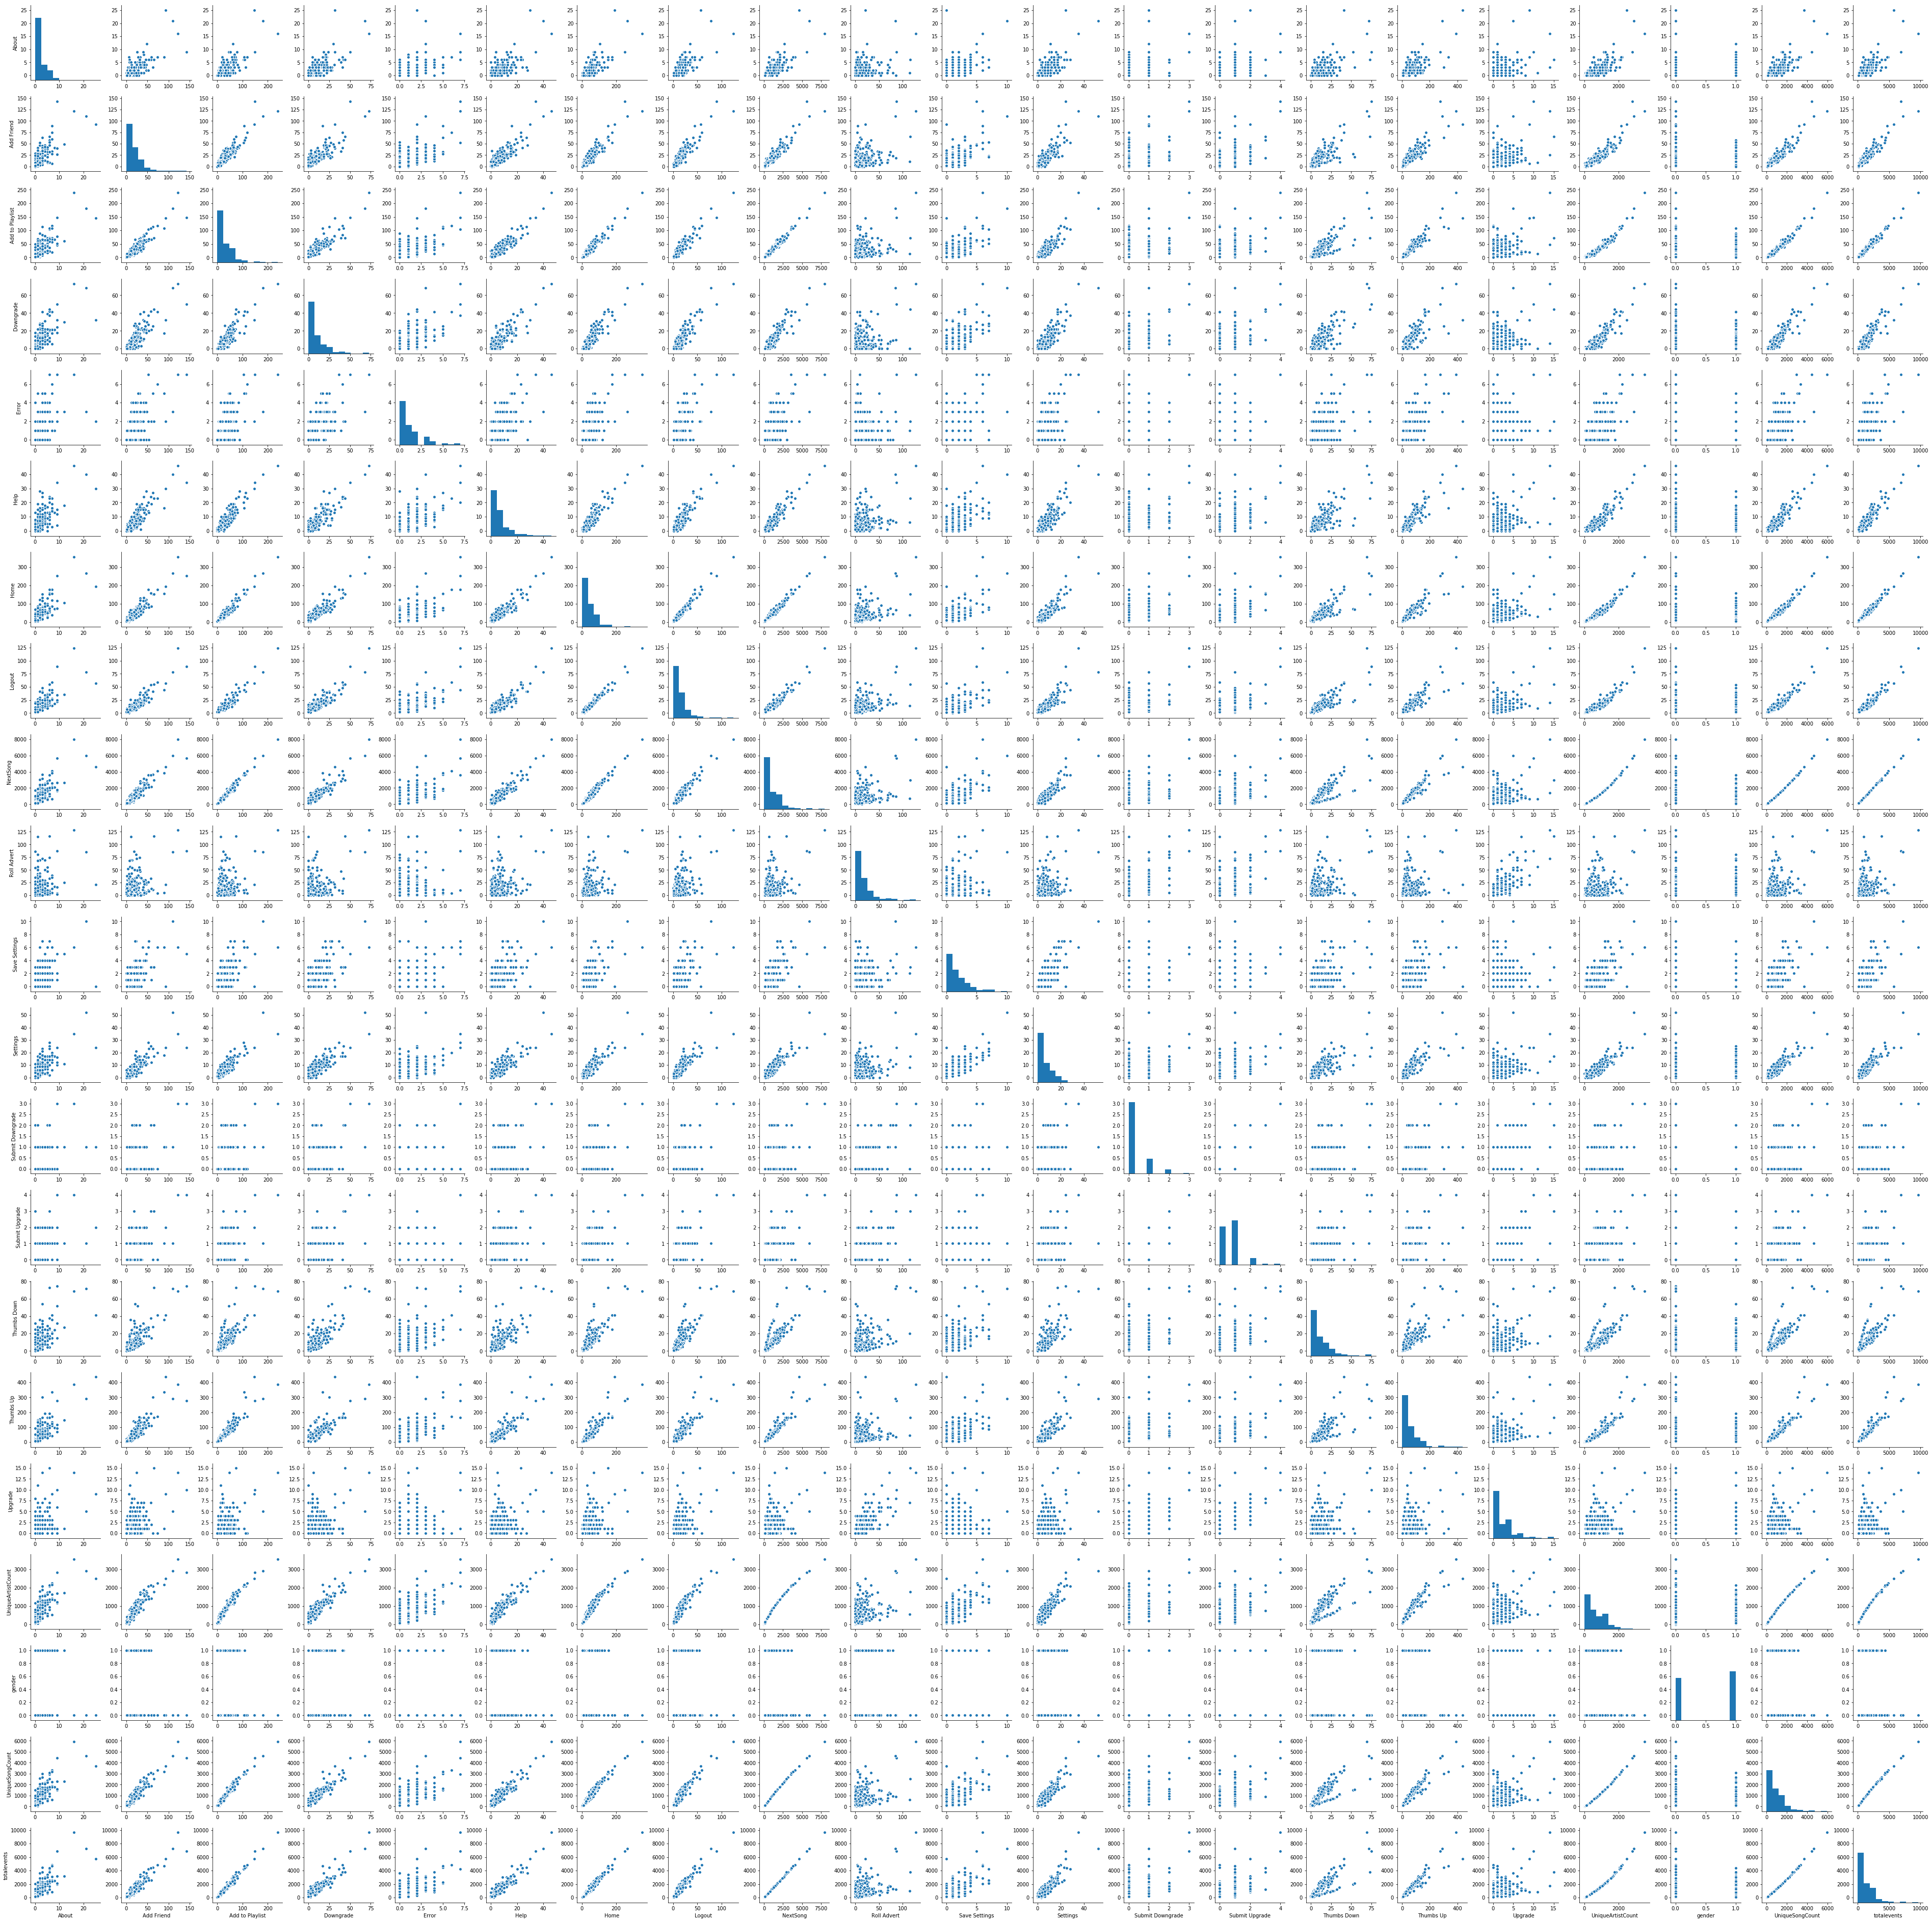

In [40]:
#let's plot the correlation between features
columns_del = ['userId', 'label']
df_feature= df_page.toPandas().drop(columns_del, axis=1)
sns.pairplot(df_feature);

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [41]:
#let's create a list of features 
col_list=df_page.columns
col_list=[e for e in col_list if e not in ('userId', 'label')]

In [42]:
# convert the features into vector
assembler = VectorAssembler(inputCols=col_list, outputCol="NumFeatures")
data = assembler.transform(df_page)

In [43]:
#Scaler the features
scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
data_scaled = scaler.transform(data)

In [44]:
#select the columns we are going to use
data_scaled = data_scaled.select(["label","features"])

In [45]:
#split the data in train and test data
train, test = data_scaled.randomSplit([0.8, 0.2], seed=42)

Now I am going to do the first aproch by selecting some models and check the performace in order to select the model to be tuned afterward.

Regarding the metrics, I am going to check the F1 score because this dataset is small and a bit unbalanced. Only to focus on accurance could not be representative.

As I am going to check different models, I am going to make a funtion to do this job and not to repeat the code.

In [46]:
def cal_metrics(prediction, model):
    
    """
    This function is for calculating the F1 Score and Acurancy of a prediction and print them
    input: prediction df from model.tranform() and model(string)
    output: Print the results
    """     
    
    f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(prediction.select(col('label'), col('prediction')))
    accuracy = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(prediction.select(col('label'), col('prediction')))
    
    print("F1 Score for {} is {}".format(model,f1))
    print("Accuracy for {} is {}".format(model,accuracy))


In [47]:
def model_result(train, test, model):
    
    """
    This function is to check the metrics of a specific model 
    input: train: df of train data, test: df of test data, model: model to be evaluated
    output: Print the F1 and Accurancy of the selected model
    """         
    start_time = time.time()
    
    # model selction
    if model == 'naive_bayes':
        cl = NaiveBayes()
    elif model == 'random_forest':
        cl = RandomForestClassifier()
    elif model == 'gradient_boosting':
        cl = GBTClassifier()
    else:
        print("Model not found, please try with: naive_bayes,random_forest or gradient_boosting" )
    
    #let's fit and transform the model 
    mod =cl.fit(train)
    predict= mod.transform(test)
    
    print('Training and Predicting Running Time (s): ', (time.time() - start_time))
    
    #print the metrics using cal_metrics funtion
    cal_metrics(predict, model)


In [48]:
model_result(train, test, 'naive_bayes')

Training and Predicting Running Time (s):  185.97512817382812
F1 Score for naive_bayes is 0.5841784989858012
Accuracy for naive_bayes is 0.7058823529411765


In [49]:
model_result(train, test, 'random_forest')

Training and Predicting Running Time (s):  260.66845750808716
F1 Score for random_forest is 0.6288515406162466
Accuracy for random_forest is 0.7058823529411765


In [50]:
model_result(train, test, 'gradient_boosting')

Training and Predicting Running Time (s):  478.44783306121826
F1 Score for gradient_boosting is 0.6574394463667821
Accuracy for gradient_boosting is 0.6764705882352942


# Tunning

As we can see that the best F1_score is for the model Random Forest ( it has also a short running time comparing gradient boosting) therfore I am going to take this model in order to tune it.

In [48]:
# Optimize a Random Forest model through Grid Search
start = timeit.default_timer()# to calculate the running time

model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.impurity, ['entropy', 'gini']) \
    .addGrid(model.maxDepth, [2, 4, 6, 8]) \
    .addGrid(model.numTrees, [10, 25, 50, 100]) \
    .build()

crossval = CrossValidator(estimator = model,
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

classification = crossval.fit(train)
prediction = classification.transform(test)

stop = timeit.default_timer()
print('Training and Predcitning Running Time: ', stop - start)

Training and Predcitning Running Time:  5879.1770779769995


In [49]:
cal_metrics(prediction, 'Random_Forest')

F1 Score for Random_Forest is 0.6591970121381886
Accuracy for Random_Forest is 0.7058823529411765


Now I am going to check the feature importance in order to have an idea which on have more information gained

In [60]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = col_list
feature_importance['importance'] = classification.bestModel.featureImportances.values.tolist()
feature_importance = feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importance

,feature,importance
0,Thumbs Down,0.120536
1,NextSong,0.085021
2,Add Friend,0.062465
3,About,0.062238
4,Roll Advert,0.059015
5,Downgrade,0.058783
6,totalevents,0.053657
7,Home,0.050868
8,Logout,0.048601
9,UniqueArtistCount,0.048128


let's plot the result

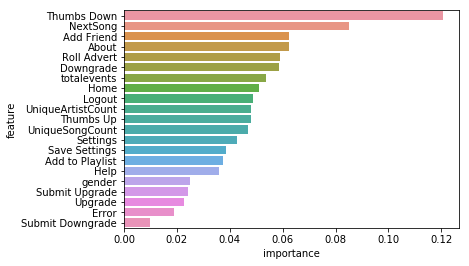

In [63]:
sns.barplot(x="importance", y="feature", data=feature_importance);

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.